[강아지 품종 데이터](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset?resource=download)

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.3 MB/s eta 0:00:00


In [3]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import imgaug as ia
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import torchvision.models as models
import numpy as np
import torchvision.transforms as transforms
import shutil
import timm
from torch.utils.data import DataLoader, dataset, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from PIL import Image
from imgaug import augmenters as iaa
from torchvision.utils import make_grid
from tqdm import tqdm
from tempfile import TemporaryDirectory
from time import time
from torch.optim import lr_scheduler

In [4]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other
100% 749M/750M [00:20<00:00, 40.9MB/s]
100% 750M/750M [00:20<00:00, 39.1MB/s]


In [5]:
!unzip -q stanford-dogs-dataset.zip

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [7]:
data_root = '/content/images/Images'
train_root = f'{data_root}/train'
val_root = f'{data_root}/val'
test_root = f'{data_root}/test'

In [8]:
cls_list = os.listdir(data_root)

cls_list[: 5]

['n02105505-komondor',
 'n02107683-Bernese_mountain_dog',
 'n02099267-flat-coated_retriever',
 'n02110063-malamute',
 'n02085620-Chihuahua']

In [9]:
for folder in [train_root, val_root, test_root] :

    if not os.path.exists(folder) :
        os.makedirs(folder)

    for cls in cls_list :
        cls_folder = f'{folder}/{cls}'

        if not os.path.exists(cls_folder) :
            os.makedirs(cls_folder)

In [10]:
random.seed(2024)

In [11]:
for cls in cls_list :
    file_list = os.listdir(f'{data_root}/{cls}')
    random.shuffle(file_list)
    test_ratio = 0.1
    num_file = len(file_list)

    test_list = file_list[: int(num_file * test_ratio)]
    val_list = file_list[int(num_file * test_ratio) : int(num_file * test_ratio) * 2]
    train_list = file_list[int(num_file * test_ratio) * 2 :]

    for i in test_list :
        shutil.copyfile(f'{data_root}/{cls}/{i}', f'{test_root}/{cls}/{i}')

    for i in val_list :
        shutil.copyfile(f'{data_root}/{cls}/{i}', f'{val_root}/{cls}/{i}')

    for i in train_list :
        shutil.copyfile(f'{data_root}/{cls}/{i}', f'{train_root}/{cls}/{i}')

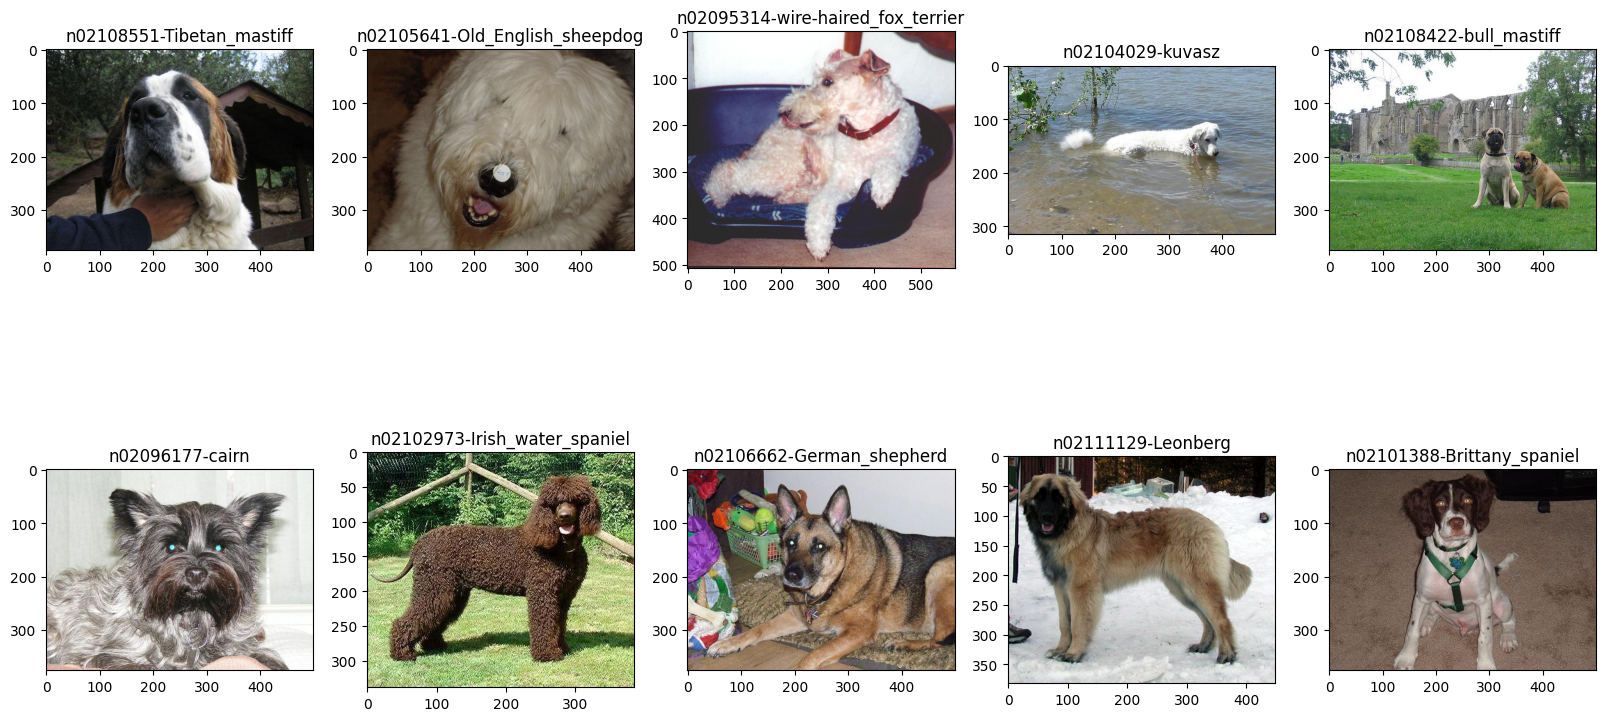

In [12]:
test_file_list = glob.glob(f"{test_root}/*/*")
random.shuffle(test_file_list)

plt.figure(figsize = (20,10))

for i in range(10):
    test_img_path = os.path.join(test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(2, 5, (i+1))
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

plt.show()

In [13]:
IMG_SIZE = 224

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [14]:
image_datasets = {x : datasets.ImageFolder(os.path.join(data_root, x),
                                           data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 16,
                                               shuffle = True, num_workers = 4) for x in ['train', 'val', 'test']}

dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 16562, 'val': 2009, 'test': 2009}
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
def train_model(model, loss_func, optim, scheduler, dataloaders, dataset_sizes,
                device, model_dir, model_name, num_epochs = 25) :

    since = time()
    with TemporaryDirectory() as tempdir :
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        # print(best_model_params_path)
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for epoch in range(num_epochs) :
            print(f'Epoch {epoch + 1} / {num_epochs}')
            print('_' * 10)

            for phase in ['train', 'val'] :

                if phase == 'train' :
                    model.train()

                else :
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase]) :
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optim.zero_grad()

                    with torch.set_grad_enabled(phase == 'train') :
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = loss_func(outputs, labels)

                        if phase == 'train' :
                            loss.backward()
                            optim.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if scheduler is not None and phase == 'train' :

                    # 학습률을 업데이트 하는 함수로 학습이 진행될 때 학습률을 동적으로 조정
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss : {epoch_loss : .4f} Acc : {epoch_acc : .4f}')

                if phase == 'train' :
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc.item())

                else :
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc.item())

                    if epoch_acc > best_acc :
                        best_acc = epoch_acc

                        if not os.path.exists(model_dir) :
                            os.makedirs(model_dir)

                        model_save_path = os.path.join(model_dir, f'{model_name}.pth')
                        torch.save(model.state_dict(), model_save_path)
            print()

        time_elapsed = time() - since
        print(f'Training Complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s')
        print(f'Best val Acc : {best_acc : .4f}')

    return [train_loss, val_loss, train_acc, val_acc]



In [16]:
data_root = './images'
model_dir = f'{data_root}/models'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

In [17]:
num_class = len(os.listdir(train_root))

print(num_class)

120


In [18]:
resnet18_model = timm.create_model('resnet18', pretrained = True, num_classes = num_class).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr = 0.0002)

# 학습률 스케쥴러 중 하나로 학습률을 단계적으로 감소시키는 기능
# step_size = 학습률이 감소하는 주기 설정(예: 10 에포크 마다 학습률이 조정)
# gamma = 학습률을 감소시킬 비율(예: 10 에포크 마다 0.9 배로 줄임)

scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [19]:
resnet18 = train_model(resnet18_model, loss_func, optimizer, scheduler, dataloaders, dataset_sizes,
                       device, model_dir, 'dog_resnet18', num_epochs = num_epochs)

Epoch 1 / 5
__________


100%|██████████| 1036/1036 [01:51<00:00,  9.29it/s]


train Loss :  3.3722 Acc :  0.2940


100%|██████████| 126/126 [00:11<00:00, 11.31it/s]


val Loss :  1.4053 Acc :  0.6491

Epoch 2 / 5
__________


100%|██████████| 1036/1036 [01:50<00:00,  9.39it/s]


train Loss :  1.9156 Acc :  0.5291


100%|██████████| 126/126 [00:09<00:00, 12.71it/s]


val Loss :  0.9741 Acc :  0.7043

Epoch 3 / 5
__________


100%|██████████| 1036/1036 [01:51<00:00,  9.30it/s]


train Loss :  1.5995 Acc :  0.5827


100%|██████████| 126/126 [00:09<00:00, 13.50it/s]


val Loss :  0.8466 Acc :  0.7262

Epoch 4 / 5
__________


100%|██████████| 1036/1036 [01:34<00:00, 11.00it/s]


train Loss :  1.4506 Acc :  0.6145


100%|██████████| 126/126 [00:11<00:00, 10.57it/s]


val Loss :  0.7911 Acc :  0.7561

Epoch 5 / 5
__________


100%|██████████| 1036/1036 [01:33<00:00, 11.08it/s]


train Loss :  1.3525 Acc :  0.6300


100%|██████████| 126/126 [00:12<00:00, 10.19it/s]


val Loss :  0.7439 Acc :  0.7680

Training Complete in  9m  37s
Best val Acc :  0.7680


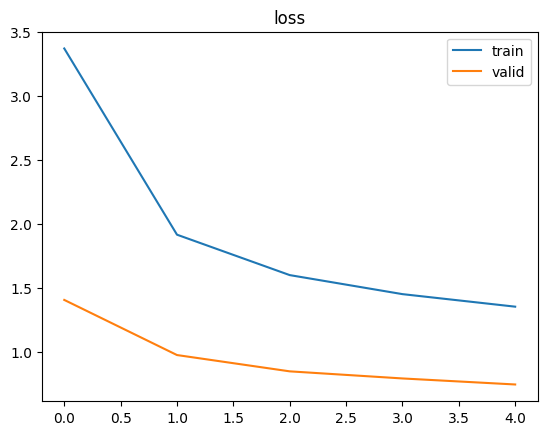

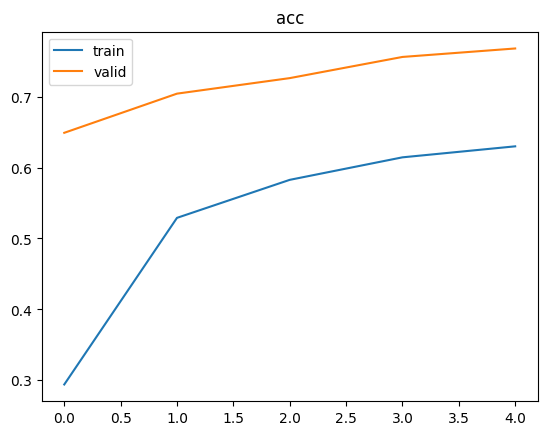

In [21]:
plt.title("loss")
plt.plot(resnet18[0], label='train')
plt.plot(resnet18[1], label='valid')
plt.legend()

plt.show()

plt.title("acc")
plt.plot(resnet18[2], label='train')
plt.plot(resnet18[3], label='valid')
plt.legend()

plt.show()

In [22]:
resnet34_model = timm.create_model('resnet34', pretrained = True, num_classes = num_class).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34_model.parameters(), lr = 0.0002)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [23]:
resnet34 = train_model(resnet34_model, loss_func, optimizer, scheduler, dataloaders, dataset_sizes,
                       device, model_dir, 'dog_resnet34', num_epochs = num_epochs)

Epoch 1 / 5
__________


  0%|          | 0/1036 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1036/1036 [01:54<00:00,  9.07it/s]


train Loss :  2.9898 Acc :  0.3963


100%|██████████| 126/126 [00:11<00:00, 10.80it/s]


val Loss :  0.7936 Acc :  0.7889

Epoch 2 / 5
__________


100%|██████████| 1036/1036 [01:54<00:00,  9.04it/s]


train Loss :  1.4570 Acc :  0.6288


100%|██████████| 126/126 [00:09<00:00, 13.65it/s]


val Loss :  0.6408 Acc :  0.7994

Epoch 3 / 5
__________


100%|██████████| 1036/1036 [01:54<00:00,  9.08it/s]


train Loss :  1.2568 Acc :  0.6661


100%|██████████| 126/126 [00:12<00:00, 10.31it/s]


val Loss :  0.5675 Acc :  0.8248

Epoch 4 / 5
__________


100%|██████████| 1036/1036 [01:56<00:00,  8.88it/s]


train Loss :  1.1605 Acc :  0.6895


100%|██████████| 126/126 [00:09<00:00, 12.78it/s]


val Loss :  0.5485 Acc :  0.8283

Epoch 5 / 5
__________


100%|██████████| 1036/1036 [01:54<00:00,  9.04it/s]


train Loss :  1.1159 Acc :  0.6942


100%|██████████| 126/126 [00:12<00:00, 10.10it/s]


val Loss :  0.5158 Acc :  0.8412

Training Complete in  10m  31s
Best val Acc :  0.8412


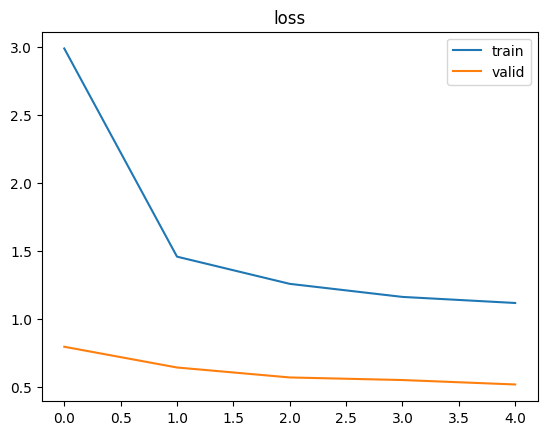

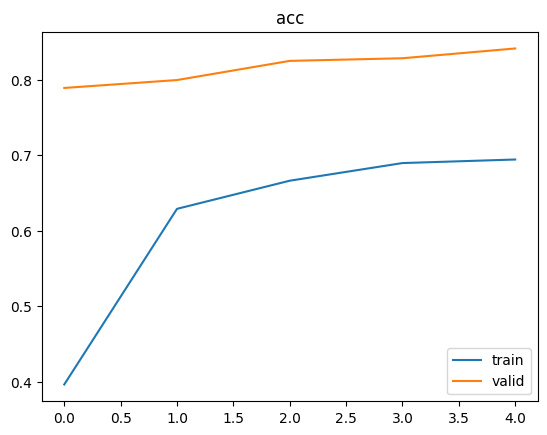

In [24]:
plt.title("loss")
plt.plot(resnet34[0], label='train')
plt.plot(resnet34[1], label='valid')
plt.legend()

plt.show()

plt.title("acc")
plt.plot(resnet34[2], label='train')
plt.plot(resnet34[3], label='valid')
plt.legend()

plt.show()

In [25]:
resnet50_model = timm.create_model('resnet50', pretrained = True, num_classes = num_class).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr = 0.0002)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [26]:
resnet50 = train_model(resnet50_model, loss_func, optimizer, scheduler, dataloaders, dataset_sizes,
                       device, model_dir, 'dog_resnet50', num_epochs = num_epochs)

Epoch 1 / 5
__________


100%|██████████| 1036/1036 [03:01<00:00,  5.71it/s]


train Loss :  2.2604 Acc :  0.5127


100%|██████████| 126/126 [00:12<00:00, 10.04it/s]


val Loss :  0.5105 Acc :  0.8447

Epoch 2 / 5
__________


100%|██████████| 1036/1036 [03:00<00:00,  5.72it/s]


train Loss :  1.1346 Acc :  0.7028


100%|██████████| 126/126 [00:12<00:00, 10.30it/s]


val Loss :  0.4348 Acc :  0.8621

Epoch 3 / 5
__________


100%|██████████| 1036/1036 [03:00<00:00,  5.74it/s]


train Loss :  1.0095 Acc :  0.7292


100%|██████████| 126/126 [00:10<00:00, 12.03it/s]


val Loss :  0.4450 Acc :  0.8626

Epoch 4 / 5
__________


100%|██████████| 1036/1036 [03:01<00:00,  5.71it/s]


train Loss :  0.9364 Acc :  0.7441


100%|██████████| 126/126 [00:09<00:00, 12.76it/s]


val Loss :  0.3963 Acc :  0.8771

Epoch 5 / 5
__________


100%|██████████| 1036/1036 [03:00<00:00,  5.74it/s]


train Loss :  0.8703 Acc :  0.7619


100%|██████████| 126/126 [00:09<00:00, 12.61it/s]

val Loss :  0.4471 Acc :  0.8631

Training Complete in  16m  2s
Best val Acc :  0.8771


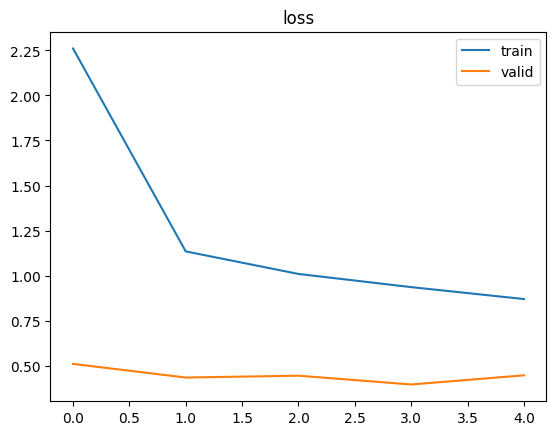

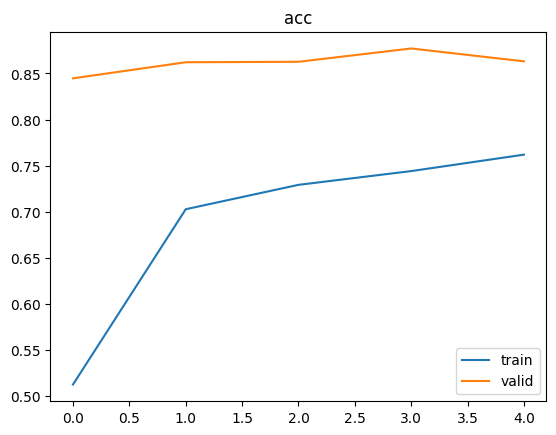

In [27]:
plt.title("loss")
plt.plot(resnet50[0], label='train')
plt.plot(resnet50[1], label='valid')
plt.legend()

plt.show()

plt.title("acc")
plt.plot(resnet50[2], label='train')
plt.plot(resnet50[3], label='valid')
plt.legend()

plt.show()

In [29]:
test_img_path = os.path.join(test_root, test_file_list[10])

test_img_path

'/content/images/Images/test/n02087394-Rhodesian_ridgeback/n02087394_7459.jpg'

In [30]:
test_data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [31]:
ori_img = Image.open(test_img_path).convert('RGB')
image = test_data_transform(ori_img)
x_tensor = image.to(device).unsqueeze(0)

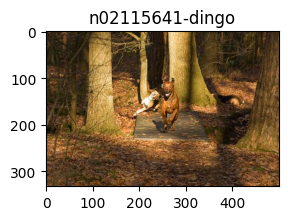

In [32]:
resnet18_model.eval()

with torch.no_grad() :
    outputs = resnet18_model(x_tensor)
    _, y_pred = torch.max(outputs, 1)

    plt.figure(figsize = (3, 3))
    plt.title(class_names[y_pred])
    plt.imshow(ori_img)
    plt.show()

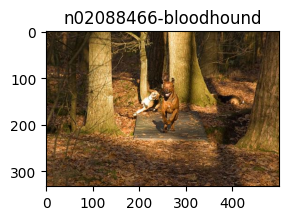

In [34]:
resnet34_model.eval()

with torch.no_grad() :
    outputs = resnet34_model(x_tensor)
    _, y_pred = torch.max(outputs, 1)

    plt.figure(figsize = (3, 3))
    plt.title(class_names[y_pred])
    plt.imshow(ori_img)
    plt.show()

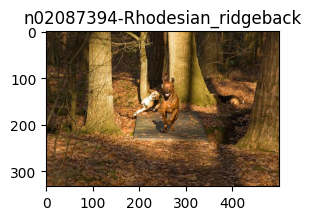

In [35]:
resnet50_model.eval()

with torch.no_grad() :
    outputs = resnet50_model(x_tensor)
    _, y_pred = torch.max(outputs, 1)

    plt.figure(figsize = (3, 3))
    plt.title(class_names[y_pred])
    plt.imshow(ori_img)
    plt.show()